# Part III - Dogs VS Cats 

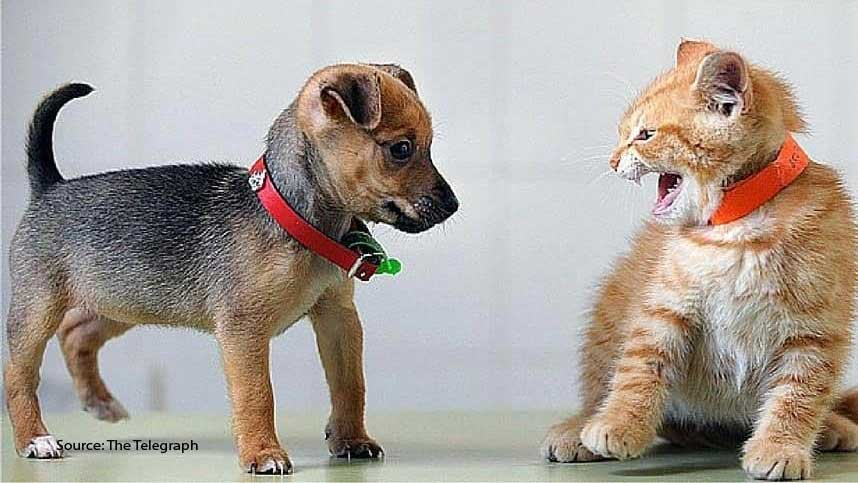

In [10]:
import cv2 # openCv
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd
import zipfile
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator 
from keras import backend
import cv2 
from keras import applications

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

##### Link to kaggle: https://www.kaggle.com/c/dogs-vs-cats

We would like to create an array which will contain our images:

In [11]:
# Extract data because we have data in zip file
with zipfile.ZipFile("C:\Haim\Anaconda\Dogs_VS_Cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("C:\Haim\Anaconda\Dogs_VS_Cats/test1.zip","r") as z:
    z.extractall(".")

In [13]:
main = "C:\Haim\Anaconda\Dogs_VS_Cats"
train = "train"
train = os.path.join(main,train)

test = "test1"
test = os.path.join(main,test)


IMAGE_FOLDER_PATH="C:\Haim\Anaconda\Dogs_VS_Cats/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

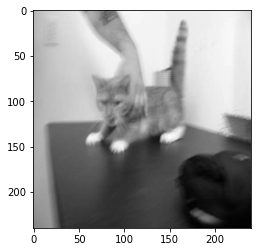

In [14]:
# random choose a single image from train dataset
for p in os.listdir(train):
    category = p.split(".")[0]
    image_read = cv2.imread(os.path.join(train,p),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(image_read,dsize=(240,240))
    plt.imshow(img,cmap="gray")
    break

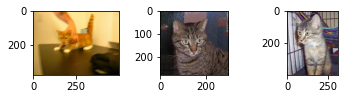

In [17]:
from matplotlib.image import imread
# create a grid of 3x3 images
for i in range(3):
    plt.subplot(331+i)
    filename = train+'/cat.'+str(i)+'.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()   

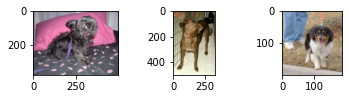

In [18]:
# create a grid of 3x3 images
for i in range(3):
    plt.subplot(331+i)
    filename=train+'/dog.'+str(i)+'.jpg'
    image=imread(filename)
    plt.imshow(image)
plt.show()  

In [7]:
#fanction that change the size and the color of the pictures 
def readImg_gray(file_path):
    img = cv2.imread(file_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    resized_img = cv2.resize(gray_img, (64,64))
    return resized_img

In [4]:
#fanction to change from tictures to Array
def TrainToArr(name, num):    
    m=12500
    n_x = 64*64
    X = np.ndarray((m,n_x), dtype=np.uint8)
    y = np.zeros((m,1))
    folder = 'train/'
    for i in range(m):
        img = readImg_gray(folder + name+ '.' + str(i) + '.jpg')
        X[i,:] = np.squeeze(img.reshape((n_x,1)))
        y[i,0] = num
    return X,y

In [8]:
#we got:
X_dog,Y_dog=TrainToArr('dog', num=1)
X_cat,Y_cat=TrainToArr('cat', num=0)

In [9]:
X_Cat=pd.DataFrame(data=X_cat)
print (X_Cat.shape)
X_Cat.head()

(12500, 4096)


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,170,176,183,188,192,196,200,202,205,208,...,10,9,3,3,3,2,2,2,2,2
1,43,42,36,29,41,43,72,38,37,37,...,77,64,38,39,56,58,53,72,68,29
2,52,46,61,64,130,134,75,210,194,171,...,60,46,60,48,48,32,49,44,42,49
3,156,169,191,190,185,141,124,127,132,201,...,133,182,192,146,190,173,195,176,171,181
4,141,158,166,172,173,177,179,181,182,184,...,12,11,11,11,13,10,11,12,10,9


In [11]:
X_Cat['label'] = Y_cat
cat_data=X_Cat
cat_data.head()
#the cat dataset

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,label
0,170,176,183,188,192,196,200,202,205,208,...,9,3,3,3,2,2,2,2,2,0.0
1,43,42,36,29,41,43,72,38,37,37,...,64,38,39,56,58,53,72,68,29,0.0
2,52,46,61,64,130,134,75,210,194,171,...,46,60,48,48,32,49,44,42,49,0.0
3,156,169,191,190,185,141,124,127,132,201,...,182,192,146,190,173,195,176,171,181,0.0
4,141,158,166,172,173,177,179,181,182,184,...,11,11,11,13,10,11,12,10,9,0.0


In [12]:
X_Dog=pd.DataFrame(data=X_dog)
print (X_Dog.shape)
X_Dog.head()

(12500, 4096)


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,115,144,161,163,131,134,128,137,140,141,...,143,96,94,84,79,75,71,76,74,86
1,110,122,101,110,94,116,107,120,119,84,...,239,247,242,233,245,246,245,240,239,233
2,178,161,164,135,165,168,162,167,166,162,...,195,190,190,193,196,199,202,206,211,217
3,227,224,203,202,211,220,223,201,195,240,...,167,171,170,171,166,168,172,168,166,164
4,150,149,149,153,153,154,157,158,151,146,...,170,166,157,152,105,65,62,56,36,38


In [13]:
X_Dog['label'] = Y_dog
dog_data= X_Dog
dog_data.head()
#the Dog dataset

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,label
0,115,144,161,163,131,134,128,137,140,141,...,96,94,84,79,75,71,76,74,86,1.0
1,110,122,101,110,94,116,107,120,119,84,...,247,242,233,245,246,245,240,239,233,1.0
2,178,161,164,135,165,168,162,167,166,162,...,190,190,193,196,199,202,206,211,217,1.0
3,227,224,203,202,211,220,223,201,195,240,...,171,170,171,166,168,172,168,166,164,1.0
4,150,149,149,153,153,154,157,158,151,146,...,166,157,152,105,65,62,56,36,38,1.0


In [15]:
train_data=pd.concat([cat_data,dog_data])
train_data=train_data.sample(frac=1)
train_data.head()
#this is our train dataset

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,label
1068,43,46,58,165,205,212,218,223,224,223,...,149,150,146,147,142,142,136,132,131,0.0
11147,104,47,154,167,65,60,204,210,215,77,...,92,89,91,91,90,94,90,86,70,1.0
11299,75,203,203,205,188,189,174,199,201,209,...,30,23,37,33,39,64,220,217,223,0.0
10539,46,71,76,86,79,167,163,111,197,162,...,98,107,107,92,140,163,161,144,161,1.0
11603,113,111,107,101,109,113,99,72,66,53,...,105,100,97,103,99,86,91,90,81,1.0


In [25]:
#lets split the data for x and y so we can to normalize the x data
data = train_data.drop(['label'],axis=1)
target = train_data['label']

In [33]:
# A function to show the labels
def num_to_name(label):
    labeled = label.copy()
    mapping = {0 :'Cat',
    1 :'Dog'}
    labeled = label.map(mapping)
    return labeled

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

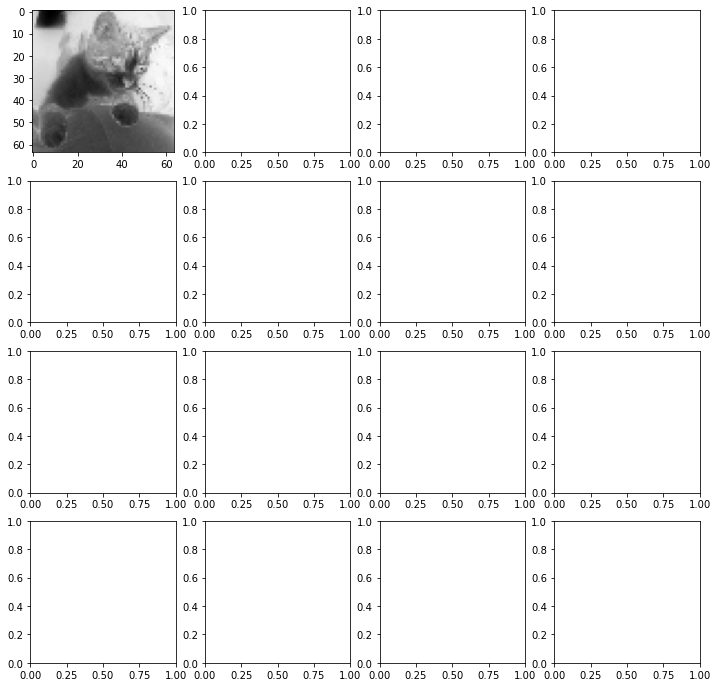

In [34]:
fig, axes = plt.subplots(4, 4, figsize = (12,12))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(data.values.reshape((data.shape[0], 64, 64))[i], cmap=plt.get_cmap('binary'))
    axes[i].set_title("Label " + str(target[i]) + ": "+ num_to_name(target)[i])
    axes[i].axis('off')
plt.show()

In [8]:
# create dataset
targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

df = pd.DataFrame()
df['image_path']=full_paths
df['target']=targets

In [9]:
df.sample(n = 4, random_state = 123).sort_values(by = 'target') # 4 random samples from the data

,image_path,target
5515,C:\Haim\Anaconda\Dogs_VS_Cats/train\cat.3711.jpg,cat
966,C:\Haim\Anaconda\Dogs_VS_Cats/train\cat.10867.jpg,cat
20000,C:\Haim\Anaconda\Dogs_VS_Cats/train\dog.5499.jpg,dog
22726,C:\Haim\Anaconda\Dogs_VS_Cats/train\dog.7952.jpg,dog


In [10]:
type(df)

pandas.core.frame.DataFrame

In [27]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (len(img), len(img[0])), interpolation=cv2.INTER_CUBIC)

In [70]:
img_g = read_image("C:\Haim\Anaconda\Dogs_VS_Cats/train\cat.3711.jpg")
img_g

array([[28, 27, 27, ..., 51, 51, 51],
       [25, 24, 24, ..., 50, 50, 50],
       [22, 21, 21, ..., 50, 50, 50],
       ...,
       [36, 36, 37, ..., 72, 72, 71],
       [35, 34, 35, ..., 71, 70, 69],
       [33, 33, 34, ..., 69, 68, 67]], dtype=uint8)

In [68]:
row = 0
for i in (0, 25000-1):
    a = read_image(df.image_path[i])
    n = len(a)
    m = len(a[0])
    row = max(n ,row)
    col = max(m, col)
print(row, col)

500 374


In [10]:
# Reading the image using imread() function
filename = train+'/dog.'+str(0)+'.jpg'
image = imread(filename)  
# Extracting the height and width of an image
h, w = image.shape[:2]
# Displaying the height and width
print("Height = {},  Width = {}".format(h, w))

Height = 375,  Width = 499


In [11]:
# Extracting RGB values. 
# Here we have randomly chosen a pixel
# by passing in 100, 100 for height and width.
(B, G, R) = image[100, 100]
  
# Displaying the pixel values
print("R = {}, G = {}, B = {}".format(R, G, B))
  
# We can also pass the channel to extract 
# the value for a specific channel
B = image[100, 100, 0]
print("B = {}".format(B))

R = 160, G = 115, B = 212
B = 212


In [12]:
# We will calculate the region of interest 
# by slicing the pixels of the image
roi = image[100 : 500, 200 : 700]

In [13]:
# resize() function takes 2 parameters, 
# the image and the dimensions
resize = cv2.resize(image, (800, 800))

In [14]:
# Using cv2.imshow() method 
# Displaying the image 
cv2.imshow('image', resize)
  
#waits for user to press any key 
#(this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0) 
  
#closing all open windows 
cv2.destroyAllWindows() 

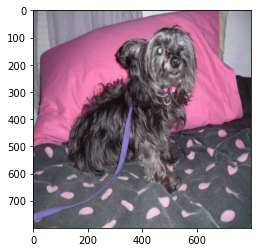

In [15]:
imgplot = plt.imshow(resize)
plt.show()

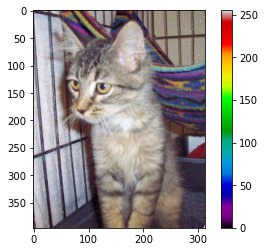

In [16]:
filename2 = train + '/cat.'+str(2)+'.jpg'
image2 = imread(filename2)  

imgplot2 = plt.imshow(image2)
imgplot2.set_cmap('nipy_spectral')
plt.colorbar()
plt.show()

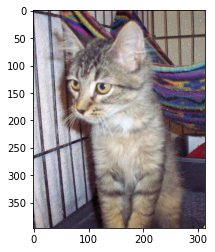

In [17]:
plt.imshow(image2)
plt.show()

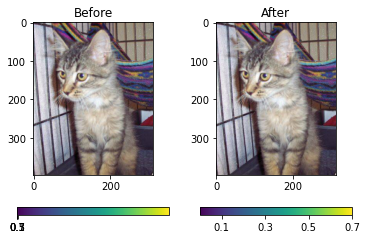

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot3 = plt.imshow(image2)
ax.set_title('Before')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
ax = fig.add_subplot(1, 2, 2)
imgplot3 = plt.imshow(image2)
imgplot3.set_clim(0.0, 0.7)
ax.set_title('After')
plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

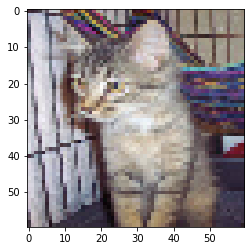

In [19]:
from PIL import Image

img = image2
img = cv2.resize(img, (60, 60))
imgplot = plt.imshow(img)


In [31]:
image = image2
print(my_image.size)
red, green, blue = div_RBG(image)
RSVD = np.linalg.svd(red)
BSVD = np.linalg.svd(blue)
GSVD = np.linalg.svd(green)
errors = dict()
k = [1, 5, 10, 15, 20, 30, 60, 100]
for i in k:
    new_red = k_best_approx(i, RSVD)
    new_blue = k_best_approx(i, BSVD)
    new_green = k_best_approx(i, GSVD)
    create_new_image(image, new_red, new_blue, new_green, i)
    errors[i] = error_value(GSVD[1], i)
for k in errors:
    print(k, " ", errors[k])


def create_new_image(org_image, red, blue, green, k):
    pix = np.array(org_image)
    new_image = np.zeros((pix.shape[0], pix.shape[1], 3))
    new_image[:, :, 0] = red
    new_image[:, :, 1] = green
    new_image[:, :, 2] = blue
    new_image = Image.fromarray(new_image.astype('uint8'))
    new_image.save(str(k)+".png")


def div_RBG(image):
    pix = np.array(image)
    return pix[:, :, 0], pix[:, :, 1], pix[:, :, 2]


def k_best_approx(k, SVD):
    sigma = np.zeros((SVD[0].shape[0], SVD[2].shape[0]))
    for i in range(k):
        sigma[i][i] = SVD[1][i]
    return SVD[0]@sigma@SVD[2]


def error_value(singular, k):
    singular_values_sq = [i ** 2 for i in singular]
    return sum(singular_values_sq[k+1:])/sum(singular_values_sq)


370656
1   0.0772642953258975
5   0.03545924846998955
10   0.021079186443050763
15   0.01369800891067717
20   0.009803244129387195
30   0.0057421784931705805
60   0.0018514176092164865
100   0.0006634792942576622


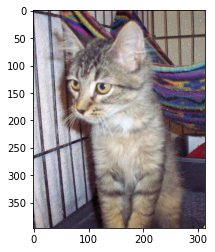

In [32]:
imgplot = plt.imshow(image)

In [33]:
image.size

370656